# 导入数据并处理

In [4]:
import pandas as pd
import pyecharts as pe
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('600177_雅戈尔.xlsx', index_col='交易日期')
df = df.sort_values(['交易日期'], ascending=True)  # 对数据进行排序,因为原始数据是按照时间降序排列的
# df.info()可以查看数据的概况，有无缺失值、数据类型等等
df.head()

,证券代码,开盘价,最高价,最低价,收盘价,成交数量(股),成交金额(元)
交易日期,,,,,,,
2010-04-28,600177-SHE,13.19,13.51,13.08,13.45,12624502,168863282
2010-04-29,600177-SHE,13.51,13.69,13.45,13.51,18351538,248816237
2010-04-30,600177-SHE,12.90,12.90,12.34,12.56,12449733,155326414
2010-05-04,600177-SHE,12.35,12.35,11.57,11.62,21145405,251908760
2010-05-05,600177-SHE,11.49,11.87,11.11,11.86,19778727,227391979


计算一些补充指标：

In [6]:
df['前收盘价'] = df['收盘价'].shift()  # 前收盘价是计算前一天的收盘价，以便后面计算其他的指标
df['涨跌幅'] = df['收盘价'] / df['前收盘价'] - 1  # 涨跌的比率
df['涨停价'] = df['前收盘价'] * 1.1  # 设置涨停以及跌停的阈值
df['跌停价'] = df['前收盘价'] * 0.9

df['资金曲线'] = (1 + df['涨跌幅']).cumprod()
# 涨跌幅+1得到的是一列值，加上括号可以作为一个序列处理，cumprod()代表累乘
# 资金曲线衡量的是股票的历史涨跌情况，初始为1
df.loc[:, '资金曲线'] = df['资金曲线'] / df['资金曲线'].iat[1]
# loc只是索引数据的标准方法，即.lov[行索引,列索引]=，就可以修改原表数据
# 然后iat[1]是为了从第二行开始取数据，因为我们的第一行有空值
df['收盘价_后复权'] = df['资金曲线'] * df['收盘价'].iat[1]
df['开盘价_后复权'] = df['开盘价'] / df['收盘价'] * df['收盘价_后复权']
df['最高价_后复权'] = df['最高价'] / df['收盘价'] * df['收盘价_后复权']
df['最低价_后复权'] = df['最低价'] / df['收盘价'] * df['收盘价_后复权']
df = df.drop(pd.to_datetime(['2010-04-28']), axis=0)  # 将第一行（有空值）删了，axis=0为行索引
df.head()

,证券代码,开盘价,最高价,最低价,收盘价,成交数量(股),成交金额(元),前收盘价,涨跌幅,涨停价,跌停价,资金曲线,收盘价_后复权,开盘价_后复权,最高价_后复权,最低价_后复权
交易日期,,,,,,,,,,,,,,,,
2010-04-29,600177-SHE,13.51,13.69,13.45,13.51,18351538,248816237,13.45,0.004461,14.795,12.105,1.000000,13.51,13.51,13.69,13.45
2010-04-30,600177-SHE,12.90,12.90,12.34,12.56,12449733,155326414,13.51,-0.070318,14.861,12.159,0.929682,12.56,12.90,12.90,12.34
2010-05-04,600177-SHE,12.35,12.35,11.57,11.62,21145405,251908760,12.56,-0.074841,13.816,11.304,0.860104,11.62,12.35,12.35,11.57
2010-05-05,600177-SHE,11.49,11.87,11.11,11.86,19778727,227391979,11.62,0.020654,12.782,10.458,0.877868,11.86,11.49,11.87,11.11
2010-05-06,600177-SHE,11.70,11.73,11.23,11.26,15157473,175016981,11.86,-0.050590,13.046,10.674,0.833457,11.26,11.70,11.73,11.23


# 绘制股票资金曲线图、K线图

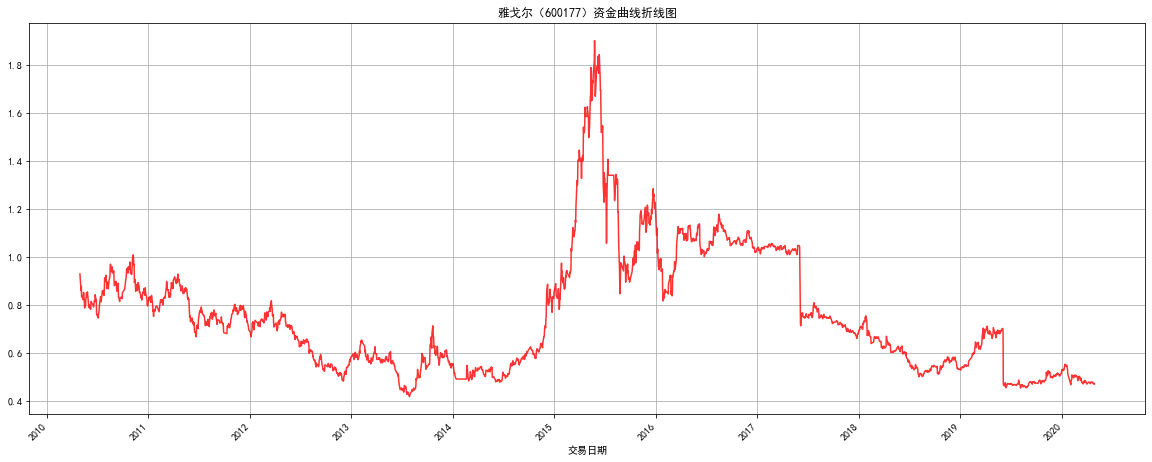

In [8]:
import matplotlib.pyplot as plt
df['资金曲线'].iloc[1::].plot(x='交易日期', y='资金曲线', figsize=(20, 8),
                          color='r', alpha=0.8,
                          grid=True,
                          rot=45,
                          title='雅戈尔（600177）资金曲线折线图')
plt.rcParams['font.sans-serif']=['SimHei']

In [9]:
x = df.index.astype('str')
y = df[['开盘价', '收盘价', '最低价', '最高价']].values

kline = pe.Kline('雅戈尔2010.4.28-2020.4.28不复权K线图')
kline.add('日k', x, y,
          is_datazoom_show=True,
          datazoom_type='both',
          datazoom_range=[80,100],
          mark_point=['max', 'min'],
          is_xaxislabel_align=True,
          tooltip_trigger='axis',
          tooltip_axispointer_type='cross')
kline